# Movement of particles in cylindrical geometry

This demo shows the movement of particles and reflection from walls.

#### Prepare simulation

Import libraries, create default configuration and get pointers to data.

In [20]:
import parfis as pfs
from parfis import Parfis
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib import animation
from copy import copy

Parfis.load_lib()
id = Parfis.newParfis()

In [21]:
Parfis.loadCfgData(id)
Parfis.setPyCfgData(id)
ptrCfgData = Parfis.getPyCfgData(id)
Parfis.loadSimData(id)
Parfis.setPySimData(id)
ptrSimData = Parfis.getPySimData(id)

Let's check the distribution of velocities and the range. By default it is set so that the velocity vector can go from zero to one $\textbf{|v|} \in (0.0, 1.0)$. This gives us the situation that in a single step the particle cant traverse more than one cell.

In [22]:
print(f"""
Initial velocity distribution = {ptrSimData.specieVec.ptr[0].velInitRandom.decode()}
Velocity is between 
    min (vx, vy, vz) = {ptrSimData.specieVec.ptr[0].velInitDistMin.asTuple()} and 
    max (vx, vy, vz) = {ptrSimData.specieVec.ptr[0].velInitDistMax.asTuple()}
""")


Initial velocity distribution = uniform
Velocity is between 
    min (vx, vy, vz) = (-0.5773502691, -0.5773502691, -0.5773502691) and 
    max (vx, vy, vz) = (0.5773502691, 0.5773502691, 0.5773502691)



We see that the velocity components go from $-\sqrt{1/3}$ to $\sqrt{1/3}$, which makes the magnitute of the velocity vector to be as described above. In order to have a smooth moving particles we need to decrees the speed, for example by 100. In the end, we can put the string directly to the config parameters.

In [23]:
print((ptrSimData.specieVec.ptr[0].velInitDistMin*0.01).asList())

[-0.005773502691, -0.005773502691, -0.005773502691]


In [24]:
cfgStr = f"""
particle.specie.a.velInitRandom = uniform <std::string>
particle.specie.a.velInitDistMin = {(ptrSimData.specieVec.ptr[0].velInitDistMin*0.01).asList()} <double>
particle.specie.a.velInitDistMax = {(ptrSimData.specieVec.ptr[0].velInitDistMax*0.01).asList()} <double>
"""
print(cfgStr)


particle.specie.a.velInitRandom = uniform <std::string>
particle.specie.a.velInitDistMin = [-0.005773502691, -0.005773502691, -0.005773502691] <double>
particle.specie.a.velInitDistMax = [0.005773502691, 0.005773502691, 0.005773502691] <double>



In [25]:
Parfis.setConfig(id, cfgStr)
Parfis.loadCfgData(id)
Parfis.loadSimData(id)
success = Parfis.runCommandChain(id, "create")
print("Create success") if success == 0 else print("Create fail")
Parfis.setPyCfgData(id)
ptrCfgData = Parfis.getPyCfgData(id)
Parfis.setPySimData(id)
ptrSimData = Parfis.getPySimData(id)
cellSize =ptrCfgData.cellSize[0]
geoSize =ptrCfgData.geometrySize[0]
cellCount =ptrCfgData.cellCount[0]
print(f"cellSize = {cellSize} meters")
print(f"geoSize = {geoSize} meters")
print(f"cellCount = {cellCount}")

Create success
cellSize = {x: 0.001, y: 0.001, z: 0.001} meters
geoSize = {x: 0.02, y: 0.02, z: 0.4} meters
cellCount = {x: 20, y: 20, z: 400}


Choose some cells that are on the boundary.

Selected 11 cells for presentation


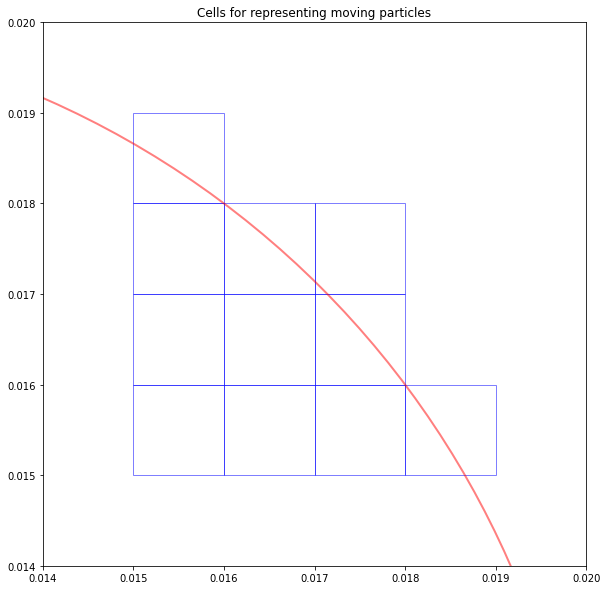

In [26]:
zSlice = 50
xRange = [i for i in range(15, 20)]
yRange = [i for i in range(15, 20)]
cellPos = pfs.Vec3DClass(pfs.Type.cellPos_t)(z=zSlice)
cellIdRange = []
for i in xRange:
    cellPos.x = i
    for j in yRange:
        cellPos.y = j
        cellId =ptrSimData.cellIdVec.ptr[pfs.getAbsoluteCellId(cellCount, cellPos)]
        if cellId != pfs.Const.noCellId:
            cellIdRange.append(cellId)
print(f"Selected {len(cellIdRange)} cells for presentation")

# Save grid patches for later drawings

# Draw the cells
fig, axGrid = plt.subplots(figsize=(10, 10))
axGrid.set_title("Cells for representing moving particles")
axGrid.plot()

gridPatches = []
for cellId in cellIdRange:
    pos =ptrSimData.cellVec.ptr[cellId].pos
    gridPatches.append (
        patches.Rectangle(
            (cellSize.x*pos.x, cellSize.y*pos.y),
            cellSize.x, cellSize.y,
            edgecolor = 'blue',
            alpha = 0.5,
            fill=False
        ) 
    )
# Draw the geometry bound
gridPatches.append (
patches.Circle(
    (geoSize.x*0.5, geoSize.y*0.5),
    radius=geoSize.x*0.5,
    lw = 2,
    edgecolor = 'red',
    alpha = 0.5,
    fill=False
    ) 
)

for i in range(len(gridPatches)):
    axGrid.add_patch(copy(gridPatches[i]))
axGrid.set_xlim((xRange[0] - 1)*cellSize.x, (xRange[-1] + 1)*cellSize.x)
axGrid.set_ylim((yRange[0] - 1)*cellSize.y, (yRange[-1] + 1)*cellSize.y)
axGrid.set_aspect('equal')
plt.show()

#### Evolve states and move particles

In [40]:
# Number of frames to run the simulation
numFrames = 50
# Size of a particle in the animation
particleSize = 0.02*cellSize.x
# Save animation as mp4
saveAnimation = True

# Dictionary of the format {stateId: [patchId, pushed]}
knownState = dict()

pc = ['blue', 'red']

# Draw the cells
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_title("Particles moving close to the boundary and reflecting")
ax.set_xlim((xRange[0] - 1)*cellSize.x, (xRange[-1] + 1)*cellSize.x)
ax.set_ylim((yRange[0] - 1)*cellSize.y, (yRange[-1] + 1)*cellSize.y)
ax.set_aspect('equal')

for i in range(len(gridPatches)):
    ax.add_patch(copy(gridPatches[i]))

def update(i):
    Parfis.runCommandChain(id, "evolve")
        
    # plt.rcParams()

    for cid in cellIdRange:
        xOff = ptrSimData.cellVec.ptr[cid].pos.x*cellSize.x
        yOff = ptrSimData.cellVec.ptr[cid].pos.y*cellSize.y
        stateId = ptrSimData.headIdVec.ptr[cid]
        while stateId != pfs.Const.noStateId:
            state = ptrSimData.stateVec.ptr[stateId]
            # If new state - add patch for it
            if stateId not in knownState.keys():
                ax.add_patch(
                    patches.Circle(
                        (
                            state.pos.x*cellSize.x + xOff, 
                            state.pos.y*cellSize.y + yOff),
                        radius=particleSize,
                        color='green',
                        fill=True
                    )
                )
                knownState[stateId] = [len(ax.patches) - 1, 1]
            # elif ptrSimData.headIdVec.ptr[cid] == stateId:
            #     knownState[stateId][0].center = (
            #         state.pos.x*cellSize.x + xOff, 
            #         state.pos.y*cellSize.y + yOff)
            #     knownState[stateId][0].set_color('orange')
            #     knownState[stateId][1] = 1
            else:                
                ax.patches[knownState[stateId][0]].center = (
                    state.pos.x*cellSize.x + xOff, 
                    state.pos.y*cellSize.y + yOff)
                ax.patches[knownState[stateId][0]].set_color('yellow')
                knownState[stateId][1] = 1

            stateId = state.next

    for stateId in knownState.keys():
        if knownState[stateId][1] == 0:
            # ax.patches.remove(knownState[stateId][0])
            # del knownState[stateId]
            ax.patches[knownState[stateId][0]].set_color('red')
        else:
            knownState[stateId][1] = 0

    return ax.patches

anim = animation.FuncAnimation(fig, update, frames=numFrames, blit=True, interval=50)

if saveAnimation:
    from IPython import display
    plt.ioff()
    video = anim.to_jshtml()
    html = display.HTML(video)
    display.display(html)
    plt.close()
else:
    plt.show()